In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdf = gpd.read_file("States shapefile/States_shapefile.shp")
gdf.drop(columns=["FID", "Program", "Flowing_St", "FID_1"], inplace=True)
gdf.head()

,State_Code,State_Name,geometry
0,AL,ALABAMA,"POLYGON ((-9469956.551 3760777.874, -9474975.1..."
1,AK,ALASKA,"MULTIPOLYGON (((-17959594.808 8122953.579, -17..."
2,AZ,ARIZONA,"POLYGON ((-12748377.957 3898982.239, -12752659..."
3,AR,ARKANSAS,"POLYGON ((-10515427.391 4055253.485, -10514418..."
4,CA,CALIFORNIA,"MULTIPOLYGON (((-13543710.331 4603367.825, -13..."


In [3]:
gdf2 = gpd.read_file("Districts shapefile\congress.shp")
gdf2.drop(columns=["congress", "fips", "name"], inplace=True)
gdf2.head()

,id,geometry
0,WA01,"POLYGON ((-122.09655 47.60231, -122.13244 47.6..."
1,WA10,"MULTIPOLYGON (((-122.22951 47.25756, -122.2188..."
2,WA02,"MULTIPOLYGON (((-122.20153 48.18791, -122.2031..."
3,WA03,"POLYGON ((-123.16053 46.83748, -123.12864 46.8..."
4,WA04,"POLYGON ((-120.70208 48.53159, -120.68853 48.5..."


In [4]:
def view_state(state:str):
    gdf2[gdf2["id"].str.contains(state)].plot(figsize=(10,10), edgecolor="black", color="lightgreen")
    plt.show()

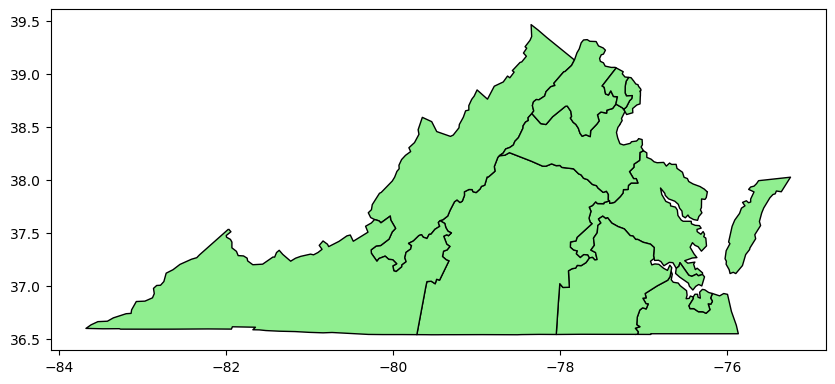

In [5]:
view_state("VA")

In [4]:
df = pd.read_csv("1976-2020-president.csv")

In [5]:
df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


In [6]:
def plot_results(year, df):
    idx = df[df["year"] == year].groupby("state")["candidatevotes"].idxmax()
    max_scores = df.loc[idx]
    res = pd.merge(gdf, max_scores, left_on="State_Name", right_on="state")
    ax = res[res["party_simplified"] == "DEMOCRAT"].plot(figsize=(10,10), edgecolor="none", color="blue")
    res[res["party_simplified"] == "REPUBLICAN"].plot(figsize=(10,10), edgecolor="none", color="red", ax=ax)
    plt.show()
    return res

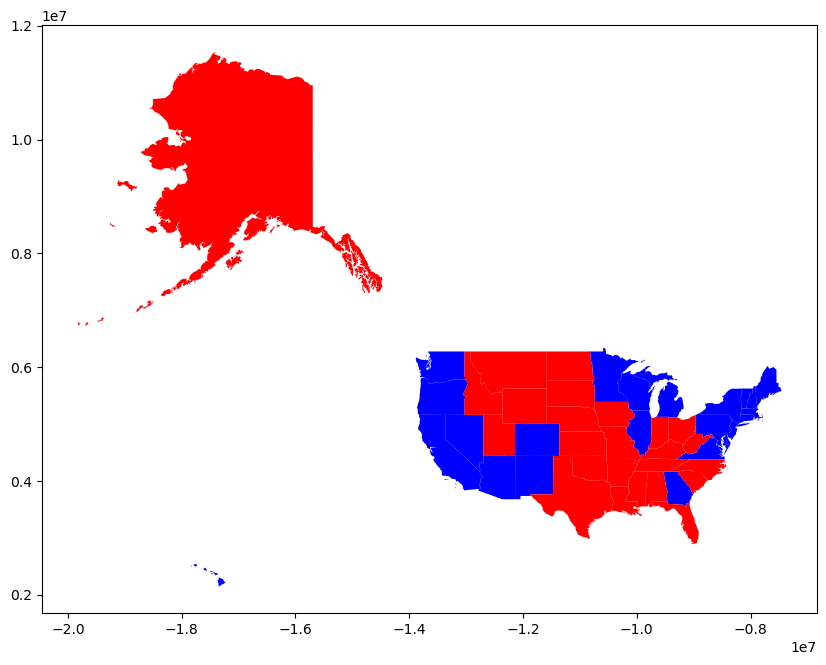

In [7]:
res = plot_results(2020, df)

In [8]:
sdf = pd.read_csv("1976-2020-senate.csv", encoding='unicode_escape')

In [9]:
polls = pd.read_csv("president_polls.csv")

In [10]:
from datetime import datetime, timedelta
bdd = datetime(year=2024, month=7, day=21)

In [11]:
polls["state"] = polls["state"].fillna("National")

In [12]:
polls["created_at"] = pd.to_datetime(polls["created_at"])

C:\Users\matth\AppData\Local\Temp\ipykernel_21728\1684343794.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  polls["created_at"] = pd.to_datetime(polls["created_at"])


In [17]:
polls["end_date"] = pd.to_datetime(polls["end_date"], format="%m/%d/%y")

In [18]:
idx = polls[(polls["state"] == "California") & (polls["created_at"] > bdd)].groupby("poll_id")["pct"].idxmax()
polls.loc[idx][["pollster","answer", "pct", "end_date"]]

,pollster,answer,pct,end_date
2193,Capitol Weekly,Harris,54.0,2024-07-14
1677,Capitol Weekly,Harris,54.0,2024-07-22
1300,Capitol Weekly,Harris,59.0,2024-07-27
725,UC Berkeley,Harris,59.0,2024-08-11
211,ActiVote,Harris,65.3,2024-08-19
414,Capitol Weekly,Harris,57.0,2024-08-15


In [19]:
harris_polls = polls.loc[polls[polls["answer"] == "Harris"].index]["question_id"]
trump_polls = polls.loc[polls[polls["answer"] == "Trump"].index]["question_id"]

In [41]:
trump_harris_polls = polls[(polls["question_id"].isin(harris_polls)) & (polls["question_id"].isin(trump_polls)) & (polls["created_at"] > bdd)]

In [21]:
trump_harris_polls["state"]

0       North Carolina
1       North Carolina
2             National
3             National
4             National
             ...      
2286      Pennsylvania
2337           Arizona
2338           Arizona
2351         Wisconsin
2352         Wisconsin
Name: state, Length: 1678, dtype: object

In [31]:
trump_harris_polls.columns

Index(['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors',
       'display_name', 'pollster_rating_id', 'pollster_rating_name',
       'numeric_grade', 'pollscore', 'methodology', 'transparency_score',
       'state', 'start_date', 'end_date', 'sponsor_candidate_id',
       'sponsor_candidate', 'sponsor_candidate_party', 'endorsed_candidate_id',
       'endorsed_candidate_name', 'endorsed_candidate_party', 'question_id',
       'sample_size', 'population', 'subpopulation', 'population_full',
       'tracking', 'created_at', 'notes', 'url', 'source', 'internal',
       'partisan', 'race_id', 'cycle', 'office_type', 'seat_number',
       'seat_name', 'election_date', 'stage', 'nationwide_batch',
       'ranked_choice_reallocated', 'ranked_choice_round', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct'],
      dtype='object')

In [42]:
trump_harris_polls["numeric_grade"].fillna(1.0, inplace=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_21728\2654200155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_harris_polls["numeric_grade"].fillna(1.0, inplace=True)


In [43]:
trump_harris_polls.numeric_grade

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2286    1.4
2337    1.4
2338    1.4
2351    1.4
2352    1.4
Name: numeric_grade, Length: 1678, dtype: float64

In [63]:
pivot = pd.pivot_table(trump_harris_polls, values="pct", columns=["answer"], index=["question_id", "pollster", "state", "end_date", "numeric_grade"])

In [64]:
pivot = pivot[pivot["Kennedy"].isnull()]

In [65]:
pivot["winner"] = pivot.idxmax(axis=1)
pivot["margin"] = np.abs(pivot["Harris"] - pivot["Trump"])
pivot.reset_index(inplace=True)
pivot["days_old"] = (datetime.now() - pivot["end_date"]).dt.days
pivot["time_weight"] = 0.95 ** pivot["days_old"]
pivot["pollster_weight"] = pivot["numeric_grade"]

In [66]:
def get_state_averages(state):
    state_df = pivot[pivot["state"] == state]
    total_weight = (state_df["time_weight"] * state_df["pollster_weight"]).sum()
    harris = (state_df["Harris"] * state_df["time_weight"] * state_df["pollster_weight"]).sum() / total_weight
    trump = (state_df["Trump"] * state_df["time_weight"] * state_df["pollster_weight"]).sum() / total_weight
    print(f"{state}\nHarris: {harris:.2f}\nTrump:  {trump:.2f}")
    if harris > trump:
        print(f"(Harris +{harris-trump:.1f})")
    elif trump > harris:
        print(f"(Trump +{trump-harris:.1f})")
    else:
        print("Tie")

In [67]:
for state in pivot["state"].unique():
    get_state_averages(state)
    print()

Georgia
Harris: 46.37
Trump:  49.83
(Trump +3.5)

National
Harris: 48.21
Trump:  45.88
(Harris +2.3)

Arizona
Harris: 47.28
Trump:  46.77
(Harris +0.5)

Michigan
Harris: 48.17
Trump:  46.37
(Harris +1.8)

Pennsylvania
Harris: 48.39
Trump:  47.72
(Harris +0.7)

Wisconsin
Harris: 48.90
Trump:  47.00
(Harris +1.9)

Maine
Harris: 57.13
Trump:  41.87
(Harris +15.3)

New Hampshire
Harris: 52.26
Trump:  46.96
(Harris +5.3)

Minnesota
Harris: 50.97
Trump:  42.92
(Harris +8.1)

Florida
Harris: 45.74
Trump:  50.74
(Trump +5.0)

Nevada
Harris: 47.18
Trump:  47.40
(Trump +0.2)

North Carolina
Harris: 47.41
Trump:  47.00
(Harris +0.4)

Oregon
Harris: 49.00
Trump:  44.00
(Harris +5.0)

Ohio
Harris: 43.22
Trump:  54.85
(Trump +11.6)

New York
Harris: 55.69
Trump:  40.37
(Harris +15.3)

Montana
Harris: 42.50
Trump:  57.50
(Trump +15.0)

Maine CD-1
Harris: 63.13
Trump:  36.65
(Harris +26.5)

Maine CD-2
Harris: 51.35
Trump:  47.87
(Harris +3.5)

Texas
Harris: 44.84
Trump:  50.33
(Trump +5.5)

California

In [69]:
pivot[pivot["state"] == "National"]

answer,question_id,pollster,state,end_date,numeric_grade,De la Cruz,Harris,Kennedy,Oliver,Stein,Terry,Trump,West,winner,margin,days_old,time_weight,pollster_weight
1,203624,SoCal Research,National,2024-07-21,1.0,NaN,43.0,NaN,NaN,NaN,NaN,51.0,NaN,Trump,8.0,39,0.135276,1.0
7,203669,Echelon Insights,National,2024-07-21,2.7,NaN,47.0,NaN,NaN,NaN,NaN,49.0,NaN,Trump,2.0,39,0.135276,2.7
8,203736,HarrisX,National,2024-07-21,1.6,NaN,47.0,NaN,NaN,NaN,NaN,53.0,NaN,Trump,6.0,39,0.135276,1.6
9,203737,HarrisX,National,2024-07-21,1.6,NaN,46.0,NaN,NaN,NaN,NaN,54.0,NaN,Trump,8.0,39,0.135276,1.6
10,203777,Morning Consult,National,2024-07-22,1.8,NaN,45.0,NaN,NaN,NaN,NaN,47.0,NaN,Trump,2.0,38,0.142396,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,207057,Florida Atlantic University/Mainstreet Research,National,2024-08-25,1.0,NaN,49.1,NaN,NaN,NaN,NaN,44.6,NaN,Harris,4.5,4,0.814506,1.0
238,207080,YouGov,National,2024-08-27,2.9,NaN,46.0,NaN,1.0,1.0,NaN,45.0,1.0,Harris,1.0,2,0.902500,2.9
239,207081,YouGov,National,2024-08-27,2.9,NaN,47.0,NaN,NaN,NaN,NaN,46.0,NaN,Harris,1.0,2,0.902500,2.9
240,207084,Quantus Polls and News,National,2024-08-27,1.0,NaN,47.1,NaN,NaN,NaN,NaN,44.6,NaN,Harris,2.5,2,0.902500,1.0
